# 4. 패션 아이템을 구분하는 DNN

## 4.0. 요약

### 4.0.1 지난장

지난 3장에서는 인공신경망 ANN의 개념에 대해서 이해했다. 인공신경망은 인간의 뉴런에서 착안하여 만들어졌으며 입력층, 은닉층, 그리고 출력층으로 구성되어 있다. 그리고 인공신경망은 층간에 element간에 연결된 가중치, 각 element별 편향, 그리고 이들의 계산을 통해 산출한 결과를 출력신호로 변환하는 활성화함수로 구성되어 있다.

* 가중치: 입력신호가 출력에 주는 영향을 계산하는 매개변수
* 편향: 각 노드가 얼마나 데이터에 민감한가
* 활성화함수: 입력신호의 합이 활성화를 일으키는지 아닌지 판단하는 함수

그리고 이렇게 인공신경망의 절차를 거쳐 출력된 예측값은 실제값과의 오차값을 활용하여, 인공신경망에 전체에 이르는 가중치를 조정하게 되는데 이것이 그 유명한 역전파알고리즘이며, 지난장에서 오차를 계산하고 손실함수의 미분 값을 활용하여 직접 경사하강법을 구현하기도 했다.

### 4.0.2. 이번장

이번장에는 입력층 - 은닉층 - 출력층이 각각 1개씩 차지하는 단순한 ANN 모델을 넘어 은닉층이 2계층 이상 있는 DNN(Deep Neural Network)에 대해 알아보려고 한다. 그리고 DNN이 어떻게 하면 과소/과대 적합을 피해 최적의 학습을 할 수 있는지에 대해서도 알아보자.

## 4.1. Fashion MNIST 데이터셋 알아보기

이번에는 글씨 분류 분제를 간단한 패션 아이템으로 확장한 Fashion MNIST 데이터셋을 살펴보자

In [1]:
import torch
from torch.utils import data
from torchvision import datasets, transforms, utils

import matplotlib.pyplot as plt
import numpy as np

torchvision.transforms 클래스는 이미지를 학습하는 데 입력된 이미지를 다양한 형태로 변형을 가함으로써 노이즈 생성 및 학습 데이터를 늘이기 위한 Data Agumentation을 위한 클래스이다. 

그리고, Albumentation이라고 pytorch에 속하지 않은 독자적인 라이브러리 또한 있다.

학습을 진행하는데 있어서 데이터는 모두 "텐서"의 형태로 표현되어야 한다. 그러므로, transform을 거치는데 있어서 ToTensor() 함으로써 결과를 텐서로 반환한다.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

우리가 사용할 Fashion MNIST 데이터 셋을 패키지에서 load한다.

이전에 수행했던 EMNIST 문제에서는 데이터를 이미 load한 상태에서, 이를 활용하여 train과 valid/test를 위한 데이터셋을 클래스로 상속을 통해 직접 만들어주고 dataloader에 배치 크기 만큼 지정하여 학습을 진행하였다.

In [3]:
trainset = datasets.FashionMNIST(
    root = './data/',
    train = True,
#     download = True,
    download = False,
    transform = transform
)

testset = datasets.FashionMNIST(
    root = './data/',
    train = False,
#     download = True,
    download = False,
    transform = transform
)

딥러닝을 학습함에 있어서 학습의 정도를 위해 선언하는 변수는 두 가지가 있다.

하나는 전체 데이터셋을 순회하는 횟수를 지정하는 epoch, 나머지는 하나의 epoch에서 몇개의 데이터마다 나누어 학습을 진행할 지를 나타내는 batch_size이다.

딥러닝은 처리해야 하는 데이터의 크기가 많이 클 수 있기 때문에 batch_size라는 개념을 도입하고 있다. 그래서 메모리의 가용량이 큰 경우는 batch_size의 양을 충분히 크게하여 학습을 진행할 수 있다.

In [4]:
batch_size = 16

train_loader = data.DataLoader(
    dataset = trainset,
    batch_size = batch_size
)

test_loader = data.DataLoader(
    dataset = testset,
    batch_size = batch_size
)

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

iterator를 통해 한 배치의 데이터를 나타내보면, 16개의 데이터가 1개의 채널에 28x28 픽셀로 표현되어 있음을 알 수 있다.

In [6]:
images.shape

torch.Size([16, 1, 28, 28])

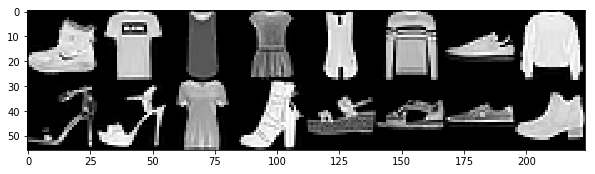

In [7]:
img = utils.make_grid(images, padding =0)
npimg = img.numpy()
plt.figure(figsize=(10,7))
plt.imshow(np.transpose(npimg,(1,2,0)))
plt.show()

In [8]:
labels

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])

데이콘 대화를 하면서 알게된 점이지만, pytorch의 torchvision.datasets를 통해 데이터셋이 만들어지는 경우 해당 클래스는 무조건 __len__ 함수와 __getitem__ 함수를 가져야 하기 때문에, 데이터셋에서 idx를 배열을 추출하는 것처럼 사용하게 되면 특정 인덱스의 데이터가 img값과 label값으로 출력된다. 

파이썬에서 len()함수와 배열처럼 추출하는 [idx]를 사용하려면 위에서 언급한 것 같이 __len__과 __getitem__ 메서드를 선언하여 사용하여야 한다. 이는 기본적으로 파이썬에서 활용하는 포맷과 같으므로 왜 그런지에 대해서는 reference를 찾아보도록 하자.

이 이야기를 하는 이유는 어떤 데이터셋에서든 모든 데이터를 간단하게 살펴보는 것이 중요하기 때문이다. 데이터를 살펴봄으로써 어떤 값들이 input으로 주어졌는지 파악할 수 있고, augmentation 등의 다음 절차를 생각해 볼 수 있기 때문이다.

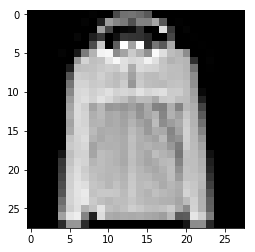

In [9]:
# 훈련셋 데이터 크기만큼의 범위 내에서 난수 생성
data_size = len(trainset)
random_value = np.random.randint(data_size)

# img 출력
img = trainset[random_value][0].squeeze()
plt.imshow(img,cmap="gray")

## 4.2. 인공 신경망으로 패션 아이템 분류하기

이번절은 3장에서 했었던 인공신경망을 구현하는 구절과 유사하다. 하지만 DNN으로써 기존에 실습했던 것과 달리 여러 층의 은닉층을 활용하여 구현을 진행한다.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

from copy import deepcopy

딥러닝은 대부분의 레퍼런스를 살펴보면 CPU가 아니라 GPU를 활용하는데, 왜 GPU를 활용하는 사례가 많은지 알고 있는가?

이는 대학원 준비 QnA 항목에 있던 내용중에 하나이며 간략히 설명해보면 아래와 같다.

<a href="https://github.com/JerryKwon/qnas-for-datascientist">QnA for DataScientist</a> (추후내용추가예정)

혹시, GPU의 코어 개수에 대해서 알고 있는가? 아마 CPU를 고를 때는 쉽게 n코어 m쓰레드와 같이 "코어"에 대한 말을 많이 들었을 것 같은데, GPU를 생각해보면 그렇지않다. 위의 내용을 정리하며 이에 대해 알게되었기 때문이다. 결론적으로 GPU의 코어 개수는 CPU와 달리 엄청나게 많다. 그러면 GPU가 CPU보다 코어가 많으니 더 좋은것 아닌가?

이 말은 너무 1차원적인 발상이다. 쉽게 말하면 양과 질의 Trade-off 관계라고 할 수 있다.

* CPU

: 구성하는 코어의 수는 작지만, 코어별 성능이 뛰어나다. 그래서 프로세스를 처리함에 있어서 병렬적으로 처리하기 보다는 직렬적으로 한 개 한 개씩 처리하는 것에 뛰어난 성능을 발휘한다.

* GPU

: 구성하는 코어의 수는 많지만, 코어별 성능이 낮다. 그래서 프로세스를 처리함에 있어서 CPU와 달리 작업량을 나눠서 처리하는 병렬적인 처리에 더 뛰어난 성능을 보인다.

GPU가 CPU보다 딥러닝을 위한 학습에서 더 뛰어난 이유는 "병렬처리"에 뛰어난 성능을 보이기 때문이다. 딥러닝은 많은양의 곱과 합의 연산으로 이뤄지고, 곱과 합 연산의 대상은 행렬이다. 행렬의 곱시간에 배웠을지 모르지만, 행렬의 곱은 특정 행의 벡터와 특정 열의 벡터의 내적을 통한 결과값들을 모아둔 것과 동일하다. 이렇게 하나의 행렬 곱에 있어서 여러개의 element 결과 값을 구하는데 있어서 절차를 병렬화하면 속도는 더 빨라지기 때문이다.

결과적으로 병렬처리의 장점 때문에 GPU보다 CPU를 사용하는 것이다.

그래서 대부분의 레퍼런스는 cuda(gpu)를 사용하지만, 환경에 따라서 cpu를 사용할 수 있기 때문에 이를 확인해야 하고, 환경에 따라 코드를 작성한다.

In [11]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cpu


In [12]:
EPOCHS = 30
BATCH_SIZE = 64

## 4.2.2. 이미지 분류를 위한 인공신경망 구현

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        # 마지막 Layer의 결과가 10인 이유는, 우리가 분류해야 할 결과의 class 개수가 10개이기 때문이다.
        self.fc3 = nn.Linear(128,10)
        
    def forward(self,x):
        layer1 = self.fc1(x)
        layer2 = self.fc2(layer1)
        layer3 = self.fc3(layer2)
        
        return layer3

learning_rate = 0.01

if USE_CUDA: 
    model = Net().to(DEVICE)
else:
    model = Net()

optimizer = optim.SGD(model.parameters(),lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [14]:
train_loader = data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE
)

test_loader = data.DataLoader(
    dataset = testset,
    batch_size = BATCH_SIZE
)

In [15]:
model.train()
best_stt_dict = deepcopy(model.state_dict())
best_loss = np.inf

for batch_num, (inputs, labels) in enumerate(train_loader):

    model.zero_grad()
    
    inputs = inputs.view(-1, 784)
    outputs = model(inputs)
    
    loss = criterion(outputs,labels)
    loss.backward()
    
    optimizer.step()
    
    output_labels = outputs.argmax(axis=1)
    accuarcy = output_labels.eq(labels.view_as(output_labels)).sum().item() / BATCH_SIZE

    if loss < best_loss:
        best_loss = loss
        best_stt_dict = deepcopy(model.state_dict())
        print("state saved at {} batch_num".format(batch_num))
    
    if batch_num % 100 == 0:
        print("batch_num: {}; loss: {}; accuracy: {}".format(batch_num, loss.item(), accuarcy))

state saved at 0 batch_num
batch_num: 0; loss: 2.2906265258789062; accuracy: 0.109375
state saved at 2 batch_num
state saved at 5 batch_num
state saved at 7 batch_num
state saved at 8 batch_num
state saved at 10 batch_num
state saved at 12 batch_num
state saved at 13 batch_num
state saved at 22 batch_num
state saved at 23 batch_num
state saved at 24 batch_num
state saved at 31 batch_num
state saved at 32 batch_num
state saved at 34 batch_num
state saved at 35 batch_num
state saved at 41 batch_num
state saved at 42 batch_num
state saved at 44 batch_num
state saved at 47 batch_num
state saved at 49 batch_num
state saved at 54 batch_num
state saved at 56 batch_num
state saved at 64 batch_num
state saved at 66 batch_num
state saved at 67 batch_num
state saved at 68 batch_num
state saved at 70 batch_num
state saved at 71 batch_num
state saved at 72 batch_num
state saved at 83 batch_num
state saved at 85 batch_num
state saved at 91 batch_num
state saved at 94 batch_num
state saved at 96 batc

In [16]:
model.load_state_dict(best_stt_dict)

model.eval()
test_loss = 0.0
running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        
        inputs = inputs.view(-1,784)
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        
        test_loss += loss / len(test_loader)
        outputs_label = outputs.argmax(axis=1)
        running_corrects += outputs_label.eq(labels).sum()
    
    test_accuracy = running_corrects.item() / len(test_loader.dataset)
    print("test prediction results. loss: {}; accuracy: {}".format(test_loss, test_accuracy))

test prediction results. loss: 0.7670938372612; accuracy: 0.7211


## 4.4. 과적합과 드롭아웃

과적합을 방지하기 위해서는 어떻게 해야할까?

일반적으로 과적합은 학습시킨 데이터에만 최적화된 학습이 되어 결과를 예측할 때 평가를 위한 데이터셋에는 예측 성능이 떨어지는 것을 일컫는다. 과적합을 방지하고 일반성을 높이기 위해서 두가지 방법이 있다.

1. 데이터 늘리기
과적합이 일어났다는 이유는 아직 일반적인 케이스들에 대한 학습이 부족하다고 할 수 있다. 따라서, 일차원적으로 과적합을 방지하기 위해서는 학습에 사용되는 데이터의 양을 늘려주는것이다. 우리는 이를 pytorch에 데이터셋을 만들때, transform 패키지를 활용하여 같은 데이터라도 기울기, 방향, 노이즈 등 다양한 제약을 주어 여러 개의 데이터가 될 수 있도록 한다.

2. 드롭아웃
데이터가 아닌 모델에 직접적인 영향을 주어 과적합을 해결하는 방법이다. 이는 학습 진행 과정에서 신경망의 일부 뉴런들에 대해 비활성화하여 사용하지 않도록 하는 것이다. 이를 통해 학습에서 배제된 뉴런 외에 다른 뉴런들에 가중치를 부여하고 개별 뉴런이 특징에 고정되는 현상을 방지한다.

In [17]:
class DropoutNet(nn.Module):
    def __init__(self, dropout_p=0.2):
        super(DropoutNet, self).__init__()
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,10)
        
        self.dropout_p = dropout_p
        
    def forward(self, x):
        x = x.view(-1,784)
        x = F.relu(self.fc1(x))
        x= F.dropout(x, training=self.training, p=self.dropout_p)
        
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training, p=self.dropout_p)
        
        x = self.fc3(x)
        return x

In [18]:
if USE_CUDA: 
    do_model = DropoutNet(dropout_p=0.2).to(DEVICE)
else:
    do_model = DropoutNet(dropout_p=0.2)
    
optimizer = optim.SGD(do_model.parameters(),lr = learning_rate)

In [19]:
do_model.train()
best_stt_dict = deepcopy(do_model.state_dict())
best_loss = np.inf

for batch_num, (inputs, labels) in enumerate(train_loader):

    do_model.zero_grad()
    
    inputs = inputs.view(-1, 784)
    outputs = do_model(inputs)
    
    loss = criterion(outputs,labels)
    loss.backward()
    
    optimizer.step()
    
    output_labels = outputs.argmax(axis=1)
    accuarcy = output_labels.eq(labels.view_as(output_labels)).sum().item() / BATCH_SIZE

    if loss < best_loss:
        best_loss = loss
        best_stt_dict = deepcopy(do_model.state_dict())
        print("state saved at {} batch_num".format(batch_num))
    
    if batch_num % 100 == 0:
        print("batch_num: {}; loss: {}; accuracy: {}".format(batch_num, loss.item(), accuarcy))

state saved at 0 batch_num
batch_num: 0; loss: 2.301131248474121; accuracy: 0.125
state saved at 4 batch_num
state saved at 7 batch_num
state saved at 8 batch_num
state saved at 12 batch_num
state saved at 13 batch_num
state saved at 23 batch_num
state saved at 26 batch_num
state saved at 46 batch_num
state saved at 47 batch_num
state saved at 50 batch_num
state saved at 56 batch_num
state saved at 62 batch_num
state saved at 66 batch_num
state saved at 70 batch_num
state saved at 72 batch_num
state saved at 74 batch_num
state saved at 77 batch_num
state saved at 80 batch_num
state saved at 93 batch_num
state saved at 94 batch_num
batch_num: 100; loss: 2.2210605144500732; accuracy: 0.3125
state saved at 103 batch_num
state saved at 105 batch_num
state saved at 115 batch_num
state saved at 118 batch_num
state saved at 126 batch_num
state saved at 129 batch_num
state saved at 135 batch_num
state saved at 140 batch_num
state saved at 144 batch_num
state saved at 151 batch_num
state saved 

In [20]:
do_model.load_state_dict(best_stt_dict)

do_model.eval()
test_loss = 0.0
running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        
        inputs = inputs.view(-1,784)
        outputs = do_model(inputs)
        loss = criterion(outputs,labels)
        
        test_loss += loss / len(test_loader)
        outputs_label = outputs.argmax(axis=1)
        running_corrects += outputs_label.eq(labels).sum()
    
    test_accuracy = running_corrects.item() / len(test_loader.dataset)
    print("test prediction results. loss: {}; accuracy: {}".format(test_loss, test_accuracy))

test prediction results. loss: 0.9327921867370605; accuracy: 0.6492
